<a href="https://colab.research.google.com/github/arbi11/CEFC-2022/blob/main/Fat_Bidi_GRU_Rescaled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In [54]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from time import time

Good to know what version of tensorflow we're using...

In [55]:
print(tf.version.VERSION)

2.8.2


# Data Acquisition and Cleanup

In [56]:
for (name, (train_url, test_url)) in {
    'M6': ('https://docs.google.com/spreadsheets/d/e/2PACX-1vStmjk37Gyxo04Jh_cR0yu-My4Y2KfiXRzNqI9iztS1V5ezxepehbmQOYSNDsao3Sxrksxr5kH0NqBg/pub?gid=405256803&single=true&output=csv',
            'https://docs.google.com/spreadsheets/d/e/2PACX-1vTCx2G0k-SUnmQxg_9TuW-o-D5Z44itWiciuHIkbGXxHPjEPBxbRVP2TMdN7GxRQtkMkkUBUv_IrLXr/pub?gid=1464939435&single=true&output=csv'),
    'M19': ('https://docs.google.com/spreadsheets/d/e/2PACX-1vTX1O03TCJYomYg1QU6SpGi-OhR_V3Kkx1Xkc2JUpaWaLlztDSLMn6eFXyFmaVZrmRIJjGoqY5LkENP/pub?gid=1103714291&single=true&output=csv',
            'https://docs.google.com/spreadsheets/d/e/2PACX-1vQQFzZz0My7iSpzHtl2K2m-2oBCHT--nqaXZiPxct4sJO2CPQWiRD6HRA8AeJHHQkY6bcu9lxatiLaP/pub?gid=1992106649&single=true&output=csv'),
    'M27': ('https://docs.google.com/spreadsheets/d/e/2PACX-1vRdXKEhlJTJJ51CppTioNYQRU7Ehq1ENVg3AeUx62jmkCe8g1miMc7yjcHmqfWyjg3bfJtRoXN77Eb-/pub?gid=635614041&single=true&output=csv',
            'https://docs.google.com/spreadsheets/d/e/2PACX-1vSMECgV6ErVI3a0_8tK6ymGVtvmff_ADVvJ6THlVTv0sL2jn3KAFcTuU04zw2LCmMxPFdY1lEzbi_aB/pub?gid=1533844294&single=true&output=csv'),
    '20PNF1500': ('https://docs.google.com/spreadsheets/d/e/2PACX-1vTBWwGhiUQBhBTGz4DZqAwDaeVxbwxWJDJZpvWQLesTYLDD8ehmMC7OENkgzyohLrCxtcbEKvaABk4Y/pub?gid=1807288876&single=true&output=csv',
                  'https://docs.google.com/spreadsheets/d/e/2PACX-1vSMlA32y9eSewKWs5j3R6FVi5-eQcUhgCzpiLUXlF8adWgScy0lw5-imD6GM0SA_-sHVM8VCtIpYhSP/pub?gid=222833859&single=true&output=csv'),
  }.items():
  print(name)

  # *  Get rid of the 5 useless rows at the beginning of each file
  # *  Normalize the column names to 't', 'Hx', 'Bx', 'Hy', 'By', 'Hz', 'Bz'
  df = pd.read_csv(train_url, skiprows=5, usecols=range(1, 8))
  df.to_csv(f"{name}_train.csv", index=False)
  print(f"  train set: {df.shape}")

  df = pd.read_csv(test_url, skiprows=5, usecols=range(1, 8))
  df.rename(columns={'H x': 'Hx', 'B x': 'Bx', 'H y': 'Hy', 'B y': 'By', 'H z': 'Hz', 'B z': 'Bz'}, inplace=True)
  df.to_csv(f"{name}_test.csv", index=False)
  print(f"  test set:  {df.shape}")

print("\nDone")

M6
  train set: (2001, 7)
  test set:  (11766, 7)
M19
  train set: (2001, 7)
  test set:  (1178, 7)
M27
  train set: (2001, 7)
  test set:  (1178, 7)
20PNF1500
  train set: (2001, 7)
  test set:  (11766, 7)

Done


And the M6 dataset with 20000 data points...

In [57]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vR4v2LZFBH-tn1nSFUkL8M3cOZSh1I1jQzXsoLyGtdt--hAgyfEYYk087pFB7iatP7FvJsdM9fvfzAG/pub?gid=1926006206&single=true&output=csv',
                 skiprows=5, usecols=range(1, 8))
df.to_csv("M6_train20000.csv", index=False)
print(f"M6 (20000 data point version): {df.shape}")
del df

M6 (20000 data point version): (20001, 7)


# Data Exploration and Visualization

## M6 (2000 data point version)

In [58]:
df = pd.read_csv('./M6_train.csv')
df

,t,Hx,Bx,Hy,By,Hz,Bz
0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0,0.000000e+00
1,0.1,0.005460,0.000075,-1.190000e-17,-2.860000e-17,0,3.172737e-315
2,0.2,0.024100,0.000329,1.640000e-14,2.480000e-16,0,3.172737e-315
3,0.3,0.042700,0.000584,1.820000e-12,-2.040000e-15,0,3.172737e-315
4,0.4,0.061300,0.000839,-2.310000e-14,-3.810000e-14,0,3.172737e-315
...,...,...,...,...,...,...,...
1996,199.6,26.553186,-0.238842,-4.110000e-10,-2.940000e-11,0,3.172737e-315
1997,199.7,27.205196,-0.188133,-3.350000e-10,-2.880000e-11,0,3.172737e-315
1998,199.8,27.729051,-0.137423,-2.390000e-10,-1.390000e-11,0,3.172737e-315
1999,199.9,28.159743,-0.086700,1.470000e-10,-1.010000e-11,0,3.172737e-315


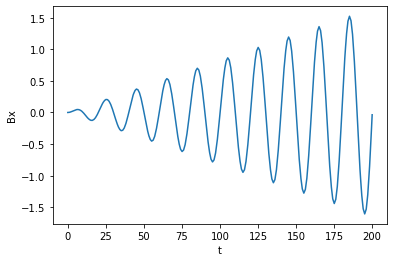

In [59]:
plt.plot(df['t'], df['Bx'], '-')
plt.xlabel('t')
plt.ylabel('Bx')
plt.show()

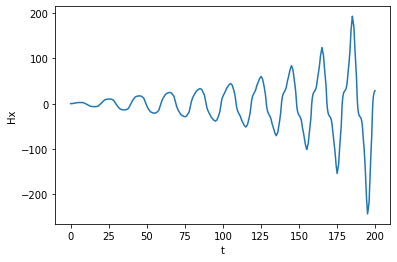

In [60]:
plt.plot(df['t'], df['Hx'])
plt.xlabel('t')
plt.ylabel('Hx')
plt.show()

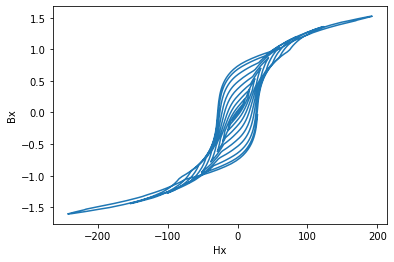

In [61]:
plt.plot(df['Hx'], df['Bx'])
plt.xlabel('Hx')
plt.ylabel('Bx')
plt.show()

## M6 (20000 data point version)

In [62]:
df = pd.read_csv('./M6_train20000.csv')
df

,t,Hx,Bx,Hy,By,Hz,Bz
0,0.00,0.000000,0.000000,0.000000e+00,0.000000e+00,0,0.0
1,0.01,0.000546,0.000007,-1.460000e-18,2.090000e-18,0,0.0
2,0.02,0.002410,0.000033,1.020000e-15,3.830000e-17,0,0.0
3,0.03,0.004280,0.000058,5.400000e-15,1.540000e-16,0,0.0
4,0.04,0.006140,0.000084,6.350000e-15,7.590000e-17,0,0.0
...,...,...,...,...,...,...,...
19996,199.96,7.536977,-0.023900,-1.470000e-09,-6.500000e-11,0,0.0
19997,199.97,7.799354,-0.018800,-1.430000e-09,-6.470000e-11,0,0.0
19998,199.98,8.057725,-0.013800,-1.400000e-09,-6.450000e-11,0,0.0
19999,199.99,8.312216,-0.008700,-1.370000e-09,-6.480000e-11,0,0.0


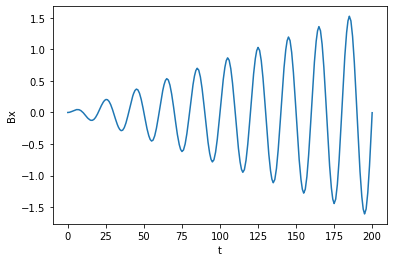

In [63]:
plt.plot(df['t'], df['Bx'], '-')
plt.xlabel('t')
plt.ylabel('Bx')
plt.show()

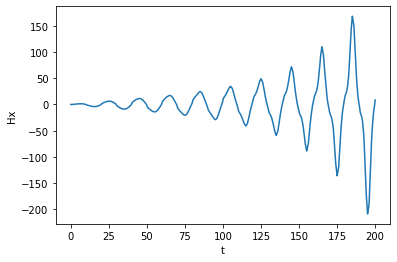

In [64]:
plt.plot(df['t'], df['Hx'])
plt.xlabel('t')
plt.ylabel('Hx')
plt.show()

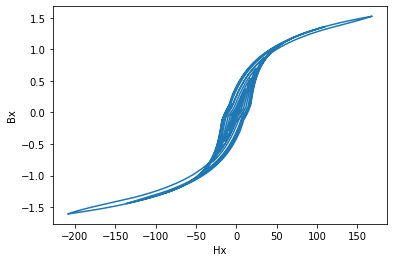

In [65]:
plt.plot(df['Hx'], df['Bx'])
plt.xlabel('Hx')
plt.ylabel('Bx')
plt.show()

## M19

In [66]:
df = pd.read_csv('./M19_train.csv')
df

,t,Hx,Bx,Hy,By,Hz,Bz
0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0,3.234392e-317
1,0.1,0.016100,0.000075,4.930000e-18,-4.960000e-18,0,3.231985e-315
2,0.2,0.070900,0.000329,1.070000e-14,6.050000e-16,0,3.231985e-315
3,0.3,0.125582,0.000584,-6.320000e-12,-1.900000e-14,0,3.231985e-315
4,0.4,0.180231,0.000838,-7.490000e-13,7.610000e-15,0,3.231985e-315
...,...,...,...,...,...,...,...
1996,199.6,54.128872,-0.238981,-4.310000e-10,-1.650000e-11,0,3.231985e-315
1997,199.7,55.785869,-0.188277,-6.320000e-10,-1.970000e-11,0,3.231985e-315
1998,199.8,56.959727,-0.137570,-7.640000e-10,-1.890000e-11,0,3.231985e-315
1999,199.9,57.788775,-0.086900,-6.110000e-10,-1.910000e-11,0,3.231985e-315


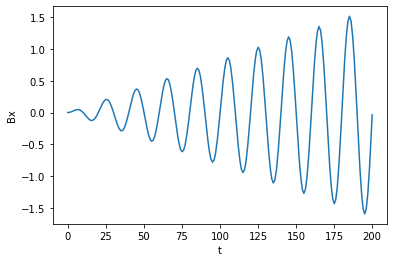

In [67]:
plt.plot(df['t'], df['Bx'])
plt.xlabel('t')
plt.ylabel('Bx')
plt.show()

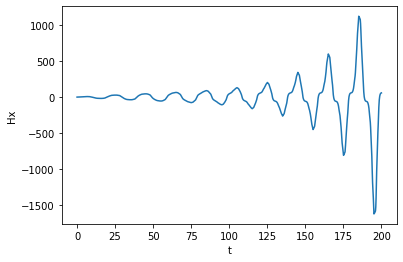

In [68]:
plt.plot(df['t'], df['Hx'])
plt.xlabel('t')
plt.ylabel('Hx')
plt.show()

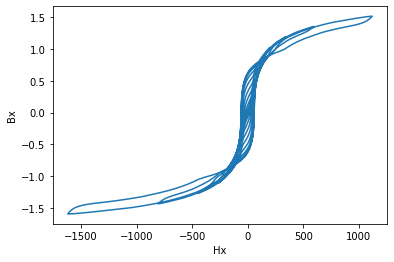

In [69]:
plt.plot(df['Hx'], df['Bx'])
plt.xlabel('Hx')
plt.ylabel('Bx')
plt.show()

## M27

In [70]:
df = pd.read_csv('./M27_train.csv')
df

,t,Hx,Bx,Hy,By,Hz,Bz
0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0,0.000000e+00
1,0.1,0.029800,0.000074,5.050000e-17,-1.030000e-17,0,3.173707e-315
2,0.2,0.131281,0.000329,-1.940000e-14,-1.540000e-15,0,3.173707e-315
3,0.3,0.232548,0.000583,2.660000e-12,5.720000e-16,0,3.173707e-315
4,0.4,0.333579,0.000837,1.590000e-12,-3.440000e-16,0,3.173707e-315
...,...,...,...,...,...,...,...
1996,199.6,83.234273,-0.239127,1.010000e-09,1.200000e-11,0,3.173707e-315
1997,199.7,84.088881,-0.188419,2.940000e-10,1.080000e-11,0,3.173707e-315
1998,199.8,84.683009,-0.137710,4.460000e-10,1.200000e-11,0,3.173707e-315
1999,199.9,85.103368,-0.087000,2.890000e-10,1.200000e-11,0,3.173707e-315


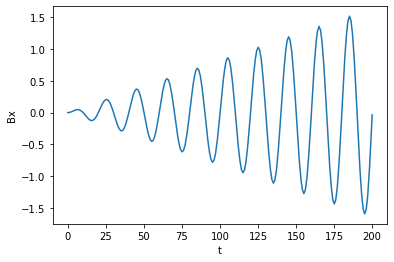

In [71]:
plt.plot(df['t'], df['Bx'], '-')
plt.xlabel('t')
plt.ylabel('Bx')
plt.show()

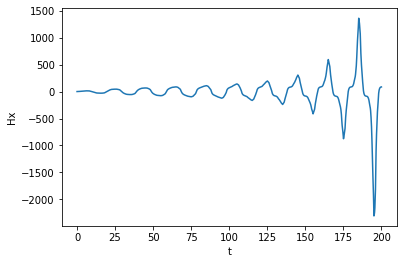

In [72]:
plt.plot(df['t'], df['Hx'])
plt.xlabel('t')
plt.ylabel('Hx')
plt.show()

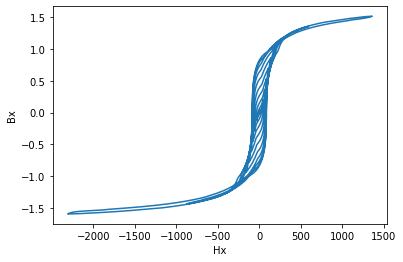

In [73]:
plt.plot(df['Hx'], df['Bx'])
plt.xlabel('Hx')
plt.ylabel('Bx')
plt.show()

## 20PNF1500

In [74]:
df = pd.read_csv('./20PNF1500_train.csv')
df

,t,Hx,Bx,Hy,By,Hz,Bz
0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0,0.000000e+00
1,0.1,0.008970,0.000075,2.070000e-18,2.190000e-17,0,3.332685e-315
2,0.2,0.039600,0.000329,-2.010000e-14,-8.070000e-16,0,3.332685e-315
3,0.3,0.070200,0.000584,-1.240000e-12,1.240000e-14,0,3.332685e-315
4,0.4,0.100677,0.000839,2.140000e-12,3.780000e-14,0,3.332685e-315
...,...,...,...,...,...,...,...
1996,199.6,24.903787,-0.238834,-7.050000e-10,-1.320000e-11,0,3.332685e-315
1997,199.7,26.197892,-0.188128,-7.090000e-10,-1.350000e-11,0,3.332685e-315
1998,199.8,27.139616,-0.137420,-6.050000e-10,-9.640000e-12,0,3.332685e-315
1999,199.9,27.827180,-0.086700,-1.980000e-10,-8.510000e-12,0,3.332685e-315


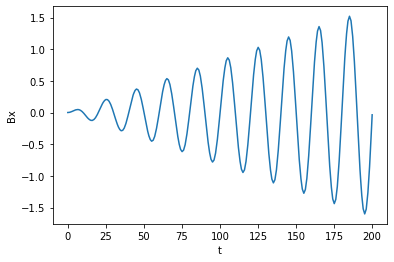

In [75]:
plt.plot(df['t'], df['Bx'], '-')
plt.xlabel('t')
plt.ylabel('Bx')
plt.show()

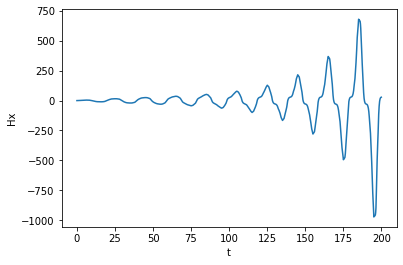

In [76]:
plt.plot(df['t'], df['Hx'])
plt.xlabel('t')
plt.ylabel('Hx')
plt.show()

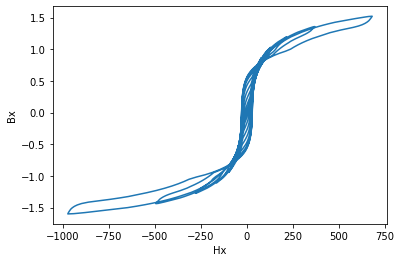

In [77]:
plt.plot(df['Hx'], df['Bx'])
plt.xlabel('Hx')
plt.ylabel('Bx')
plt.show()

# Training and Testing Sets

In this one, we do one extra thing, which is to one-hot encoding them as follows:

 Material | Pattern
----------|--------
M6        | 1000
M19       | 0100
M27       | 0010
20PNF1500 | 0001

In [78]:
def generate_timesteps(df, offset, window=1, max_offs=4):
  assert window > 0
  assert 0 <= offset < max_offs

  y = np.zeros((len(df), window, 1))
  x = np.zeros((len(df), window, 2 + max_offs))

  for w in range(window):
    y[w:, window - w - 1, 0] = df['Bx'][:len(df) - w]

  for w in range(window):
    x[w:, window - w - 1, 0] = df['Hx'][:len(df) - w]

  for w in range(window):
    x[w + 1:, window - w - 1, 1] = df['Bx'][:len(df) - w - 1]

  x[:, :, 2 + offset] = 1

  return (x, y[:, -1, :])

## M6 (2000 data point version)

In [79]:
(M6_train_X, M6_train_Y) = generate_timesteps(pd.read_csv('./M6_train.csv'), offset=3, window=30)
(M6_test_X, M6_test_Y)   = generate_timesteps(pd.read_csv('./M6_test.csv'), offset=3, window=30)

print("Training Set")
print(f"  X: {M6_train_X.shape}")
print(f"  Y: {M6_train_Y.shape}")

print("Testing Set")
print(f"  X: {M6_test_X.shape}")
print(f"  Y: {M6_test_Y.shape}")

Training Set
  X: (2001, 30, 6)
  Y: (2001, 1)
Testing Set
  X: (11766, 30, 6)
  Y: (11766, 1)


## M6 (20000 data point version)

In [80]:
(M6_20000_train_X, M6_20000_train_Y) = generate_timesteps(pd.read_csv('./M6_train20000.csv'), offset=3, window=30)

print("Training Set")
print(f"  X: {M6_20000_train_X.shape}")
print(f"  Y: {M6_20000_train_Y.shape}")

Training Set
  X: (20001, 30, 6)
  Y: (20001, 1)


## M19

In [81]:
(M19_train_X, M19_train_Y) = generate_timesteps(pd.read_csv('./M19_train.csv'), offset=2, window=30)
(M19_test_X, M19_test_Y)   = generate_timesteps(pd.read_csv('./M19_test.csv'), offset=2, window=30)

print("Training Set")
print(f"  X: {M19_train_X.shape}")
print(f"  Y: {M19_train_Y.shape}")

print("Testing Set")
print(f"  X: {M19_test_X.shape}")
print(f"  Y: {M19_test_Y.shape}")

Training Set
  X: (2001, 30, 6)
  Y: (2001, 1)
Testing Set
  X: (1178, 30, 6)
  Y: (1178, 1)


## M27

In [82]:
(M27_train_X, M27_train_Y) = generate_timesteps(pd.read_csv('./M27_train.csv'), offset=1, window=30)
(M27_test_X, M27_test_Y)   = generate_timesteps(pd.read_csv('./M27_test.csv'), offset=1, window=30)

print("Training Set")
print(f"  X: {M27_train_X.shape}")
print(f"  Y: {M27_train_Y.shape}")

print("Testing Set")
print(f"  X: {M27_test_X.shape}")
print(f"  Y: {M27_test_Y.shape}")

Training Set
  X: (2001, 30, 6)
  Y: (2001, 1)
Testing Set
  X: (1178, 30, 6)
  Y: (1178, 1)


## 20PNF1500

In [83]:
(_20PNF1500_train_X, _20PNF1500_train_Y) = generate_timesteps(pd.read_csv('./20PNF1500_train.csv'), offset=0, window=30)
(_20PNF1500_test_X, _20PNF1500_test_Y)   = generate_timesteps(pd.read_csv('./20PNF1500_test.csv'), offset=0, window=30)

print("Training Set")
print(f"  X: {_20PNF1500_train_X.shape}")
print(f"  Y: {_20PNF1500_train_Y.shape}")

print("Testing Set")
print(f"  X: {_20PNF1500_test_X.shape}")
print(f"  Y: {_20PNF1500_test_Y.shape}")

Training Set
  X: (2001, 30, 6)
  Y: (2001, 1)
Testing Set
  X: (11766, 30, 6)
  Y: (11766, 1)


## Squashed

In [84]:
Squashed_train_X = np.concatenate([
    M6_train_X,
    # M6_20000_train_X,
    M19_train_X,
    M27_train_X,
    _20PNF1500_train_X
])

Squashed_train_Y = np.concatenate([
    M6_train_Y,
    # M6_20000_train_Y,
    M19_train_Y,
    M27_train_Y,
    _20PNF1500_train_Y
])

print("Squashed Training Set")
print(f"  X: {Squashed_train_X.shape}")
print(f"  Y: {Squashed_train_Y.shape}")

Squashed Training Set
  X: (8004, 30, 6)
  Y: (8004, 1)


# ML Models

## GRU1

In [85]:
def new_model_gru1():
  input = tf.keras.Input(shape=(None, 6))

  x = tf.keras.layers.GRU(32, return_sequences=True)(input)
  x = tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(1),
        merge_mode='ave')(x)

  model = tf.keras.Model(input, x)
  return model

new_model_gru1().summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 6)]         0         
                                                                 
 gru_4 (GRU)                 (None, None, 32)          3840      
                                                                 
 bidirectional_2 (Bidirectio  (None, 1)                210       
 nal)                                                            
                                                                 
Total params: 4,050
Trainable params: 4,050
Non-trainable params: 0
_________________________________________________________________


# Model Utilities

In [86]:
def compile_and_fit(model, train_X, train_Y,
                    epochs=1000,
                    patience=10,
                    min_delta=0,
                    batch_size=50,
                    seed=9763):
  if seed is not None:
    np.random.seed(seed)
    tf.random.set_seed(seed)

  model.compile(loss='mse', optimizer='adam')
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    mode='auto',
                                                    verbose=0,
                                                    min_delta=min_delta,
                                                    patience=patience)
  
  # sneaky normalization
  train_X = np.array(train_X, copy=True)
  train_Y = np.array(train_Y, copy=True)
  train_X[:, :, 1] /= 1.5
  train_Y /= 1.5
  np.clip(train_Y, -1, 1, out=train_Y)

  return model.fit(train_X, train_Y,
                   epochs=epochs,
                   batch_size=batch_size,
                   callbacks=[early_stopping])

In [87]:
def plot_train_stats(history):
  plt.plot(history.history['loss'])
  plt.title('Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.show()

In [88]:
def plot_predictions(pred, actual, **kwargs):
  (fig, ax) = plt.subplots(2, sharex=True, **kwargs)

  ax[0].plot(actual, label='expected')
  ax[0].plot(pred, label='prediction')
  ax[0].set_ylabel('Bx')
  ax[0].legend()

  ax[1].plot(np.abs(actual - pred))
  ax[1].set_ylabel('delta')
  ax[1].grid()

  plt.xlabel('t')
  plt.show()

  print(f"MSE: {np.square(actual - pred).mean()}")

In [89]:
def inference_loop(model, data_X):
  data_X = np.array(data_X, copy=True)

  # sneaky normalization
  data_X[:, :, 1] /= 1.5

  y = np.empty(len(data_X))
  print(f"Start inference loop on {len(data_X)} samples...", end="")
  start = time()
  for i in range(len(data_X) - 1):
    y[i] = model.predict(data_X[i, None]).flatten()[-1]

    data_X[i + 1, :-1, 1] = data_X[i, 1:, 1]
    data_X[i + 1, -1, 1] = y[i]

  i = len(data_X) - 1
  y[i] = model.predict(data_X[i, None]).flatten()[-1]
  end = time()
  print(f" DONE after {end - start}s")
  return y.reshape((-1, 1)) * 1.5   # undo Bx normalization

# Model Performance

## GRU1

### Training

Epoch 1/1000
161/161 [==============================] - 11s 32ms/step - loss: 0.0498
Epoch 2/1000
161/161 [==============================] - 5s 32ms/step - loss: 0.0131
Epoch 3/1000
161/161 [==============================] - 5s 32ms/step - loss: 0.0060
Epoch 4/1000
161/161 [==============================] - 5s 32ms/step - loss: 0.0031
Epoch 5/1000
161/161 [==============================] - 5s 32ms/step - loss: 0.0019
Epoch 6/1000
161/161 [==============================] - 5s 33ms/step - loss: 0.0015
Epoch 7/1000
161/161 [==============================] - 5s 34ms/step - loss: 0.0012
Epoch 8/1000
161/161 [==============================] - 5s 32ms/step - loss: 0.0010
Epoch 9/1000
161/161 [==============================] - 5s 32ms/step - loss: 9.1372e-04
Epoch 10/1000
161/161 [==============================] - 5s 32ms/step - loss: 7.9883e-04
Epoch 11/1000
161/161 [==============================] - 5s 32ms/step - loss: 7.1951e-04
Epoch 12/1000
161/161 [==============================] - 5s 3

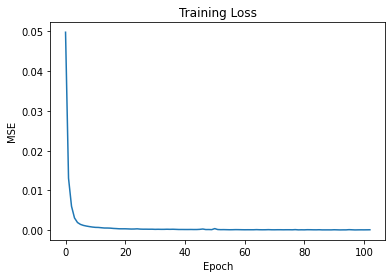

In [90]:
model = new_model_gru1()
history = compile_and_fit(model, Squashed_train_X, Squashed_train_Y)
model.save('./Model_GRU1_Squashed')
plot_train_stats(history)
del model, history

### M6 (2000 data point version)

Start inference loop on 2001 samples... DONE after 108.70444202423096s


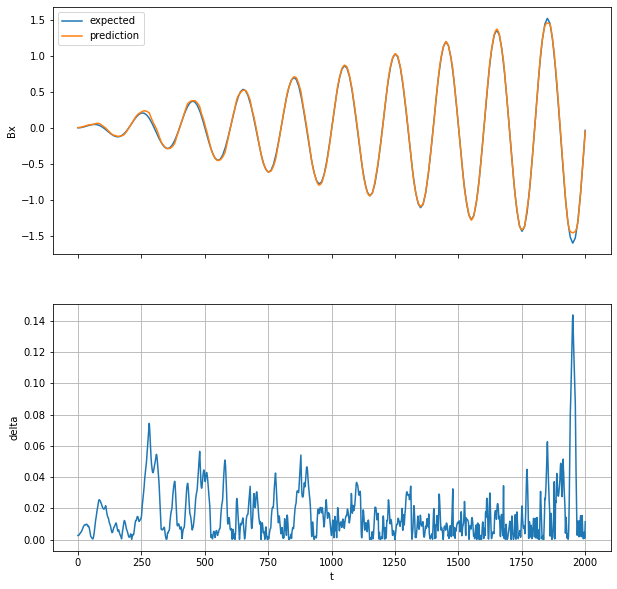

MSE: 0.0005284286170885494


In [91]:
model = tf.keras.models.load_model('./Model_GRU1_Squashed')
pred = inference_loop(model, M6_train_X)
del model

plot_predictions(pred, M6_train_Y, figsize=(10, 10))

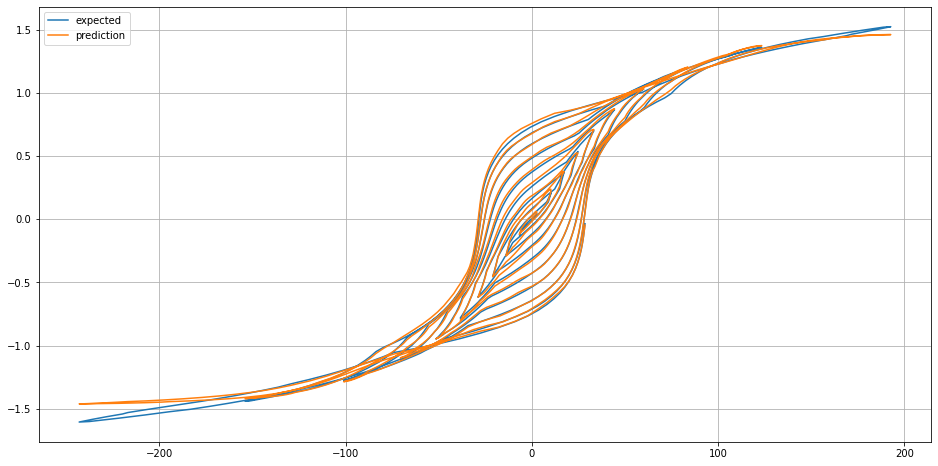

In [92]:
plt.figure(figsize=(16, 8))
plt.plot(M6_train_X[:, -1, 0], M6_train_Y, label='expected')
plt.plot(M6_train_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

Start inference loop on 11766 samples... DONE after 611.0447516441345s


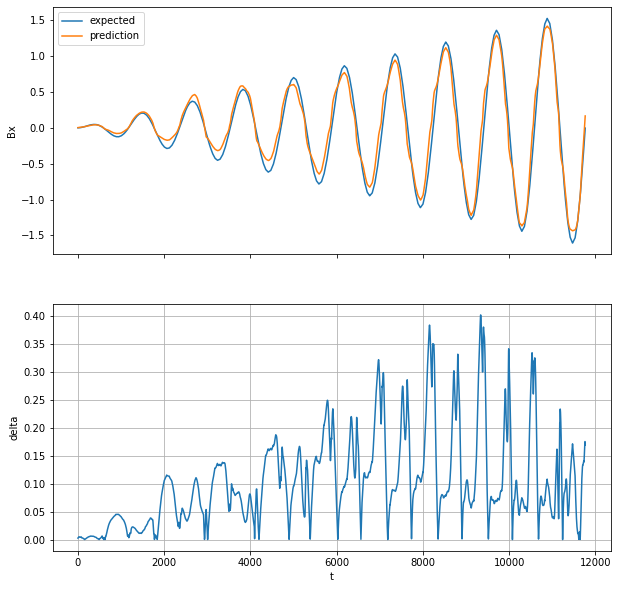

MSE: 0.01763901379211894


In [93]:
model = tf.keras.models.load_model('./Model_GRU1_Squashed')
pred = inference_loop(model, M6_test_X)
del model

plot_predictions(pred, M6_test_Y, figsize=(10, 10))

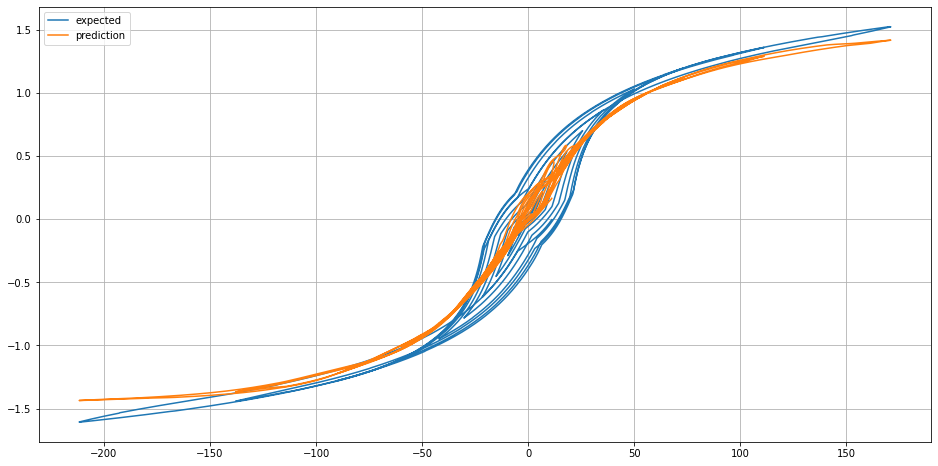

In [94]:
plt.figure(figsize=(16, 8))
plt.plot(M6_test_X[:, -1, 0], M6_test_Y, label='expected')
plt.plot(M6_test_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

### M19

Start inference loop on 2001 samples... DONE after 103.40505051612854s


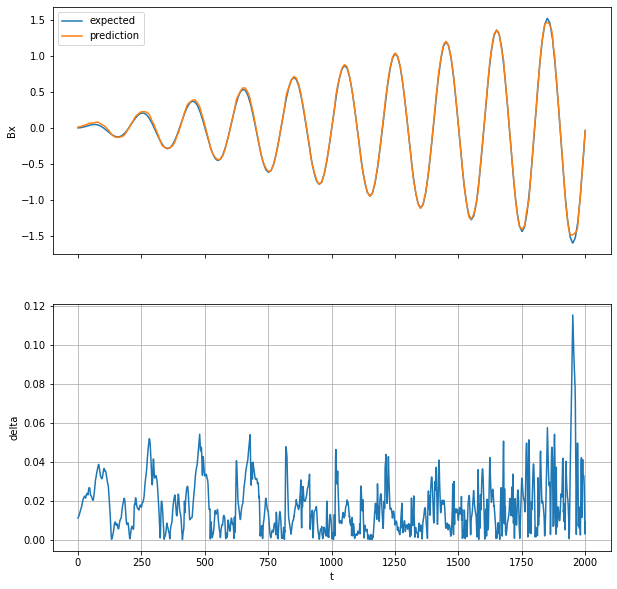

MSE: 0.0004953744791903832


In [95]:
model = tf.keras.models.load_model('./Model_GRU1_Squashed')
pred = inference_loop(model, M19_train_X)
del model

plot_predictions(pred, M19_train_Y, figsize=(10, 10))

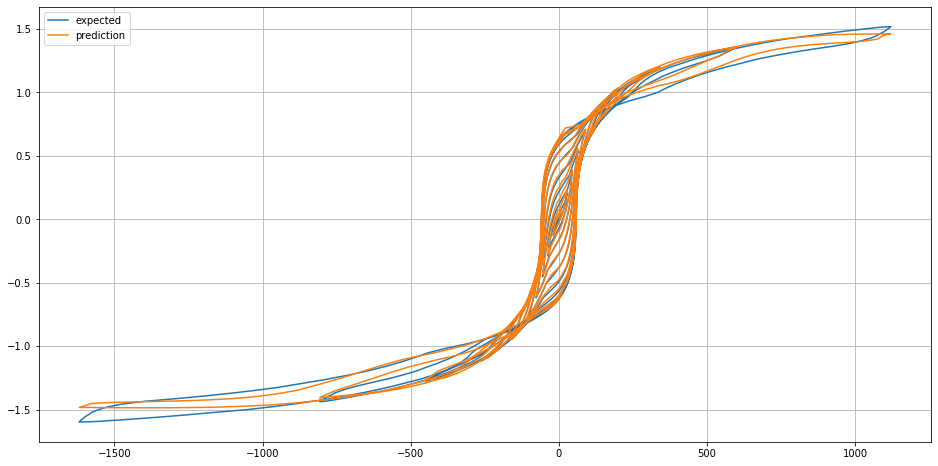

In [96]:
plt.figure(figsize=(16, 8))
plt.plot(M19_train_X[:, -1, 0], M19_train_Y, label='expected')
plt.plot(M19_train_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

Start inference loop on 1178 samples... DONE after 61.58967399597168s


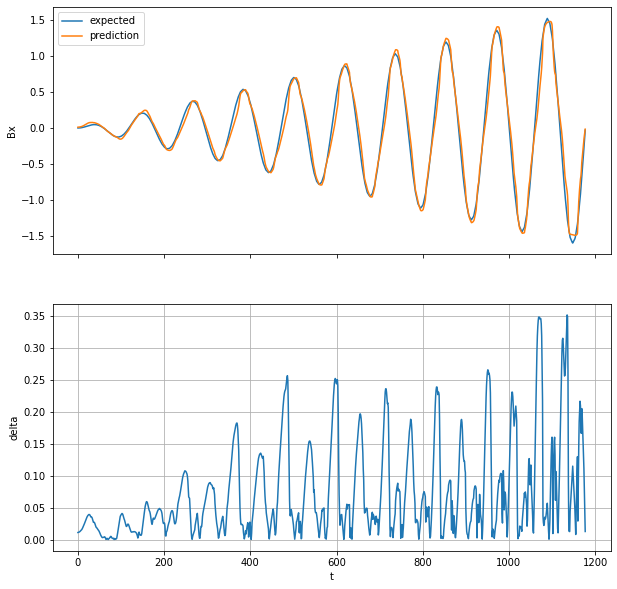

MSE: 0.01099742799683705


In [97]:
model = tf.keras.models.load_model('./Model_GRU1_Squashed')
pred = inference_loop(model, M19_test_X)
del model

plot_predictions(pred, M19_test_Y, figsize=(10, 10))

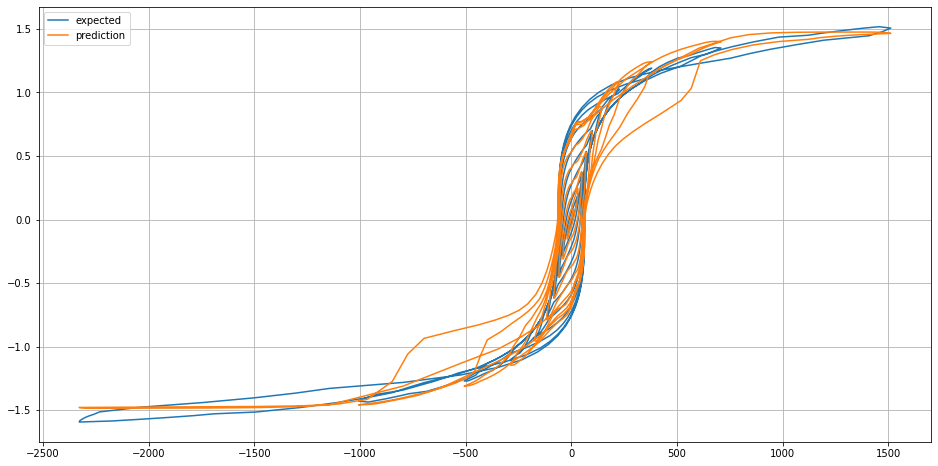

In [98]:
plt.figure(figsize=(16, 8))
plt.plot(M19_test_X[:, -1, 0], M19_test_Y, label='expected')
plt.plot(M19_test_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

### M27

Start inference loop on 2001 samples... DONE after 102.60728168487549s


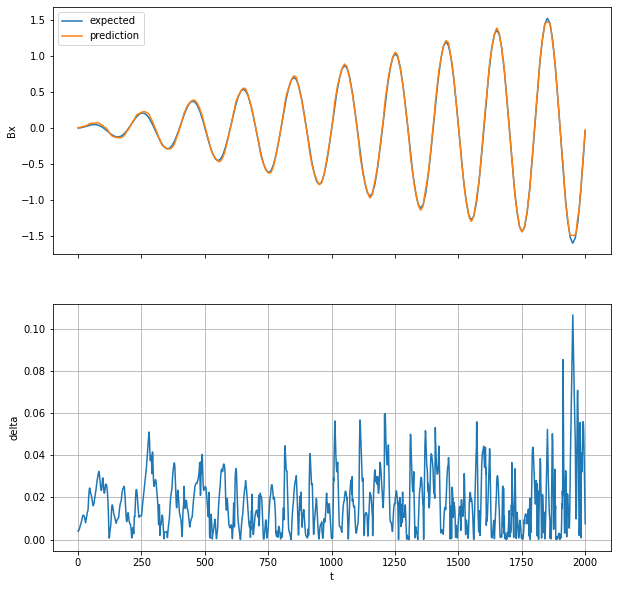

MSE: 0.0005061450520087472


In [99]:
model = tf.keras.models.load_model('./Model_GRU1_Squashed')
pred = inference_loop(model, M27_train_X)
del model

plot_predictions(pred, M27_train_Y, figsize=(10, 10))

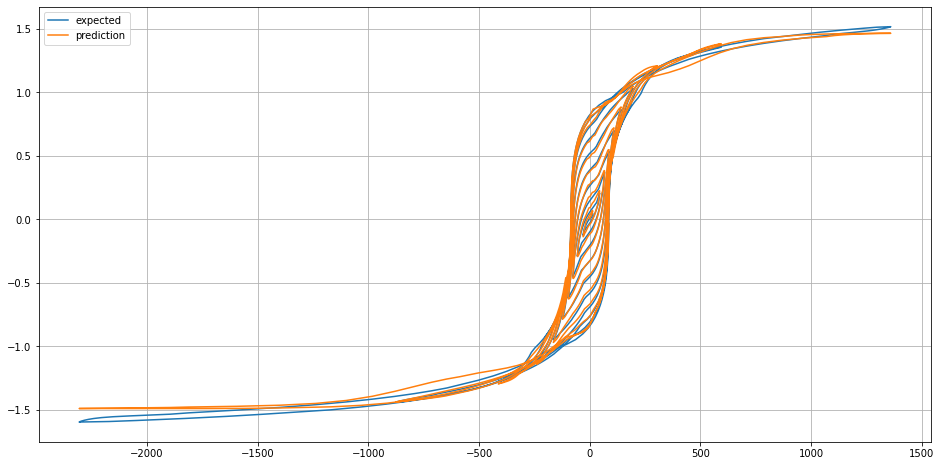

In [100]:
plt.figure(figsize=(16, 8))
plt.plot(M27_train_X[:, -1, 0], M27_train_Y, label='expected')
plt.plot(M27_train_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

Start inference loop on 1178 samples... DONE after 60.34076499938965s


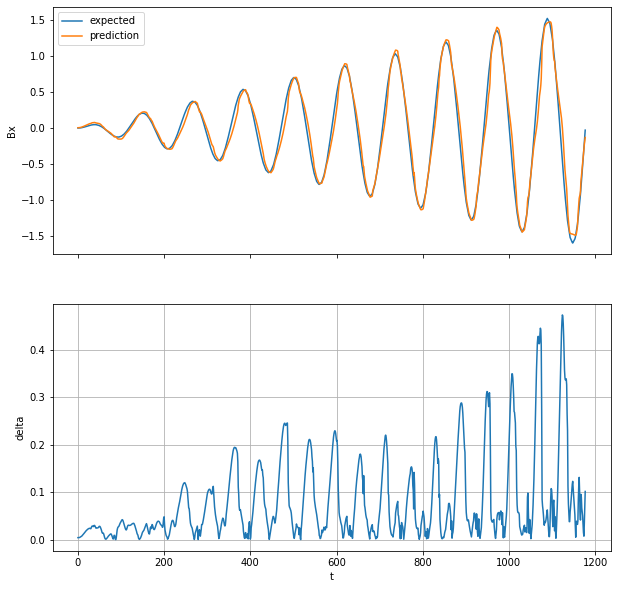

MSE: 0.014105569350027854


In [101]:
model = tf.keras.models.load_model('./Model_GRU1_Squashed')
pred = inference_loop(model, M27_test_X)
del model

plot_predictions(pred, M27_test_Y, figsize=(10, 10))

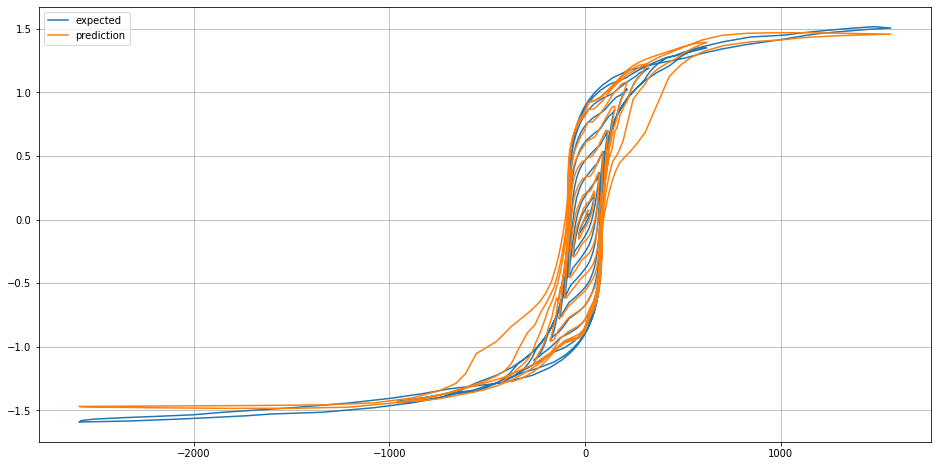

In [102]:
plt.figure(figsize=(16, 8))
plt.plot(M27_test_X[:, -1, 0], M27_test_Y, label='expected')
plt.plot(M27_test_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

### 20PNF1500

Start inference loop on 2001 samples... DONE after 102.2130115032196s


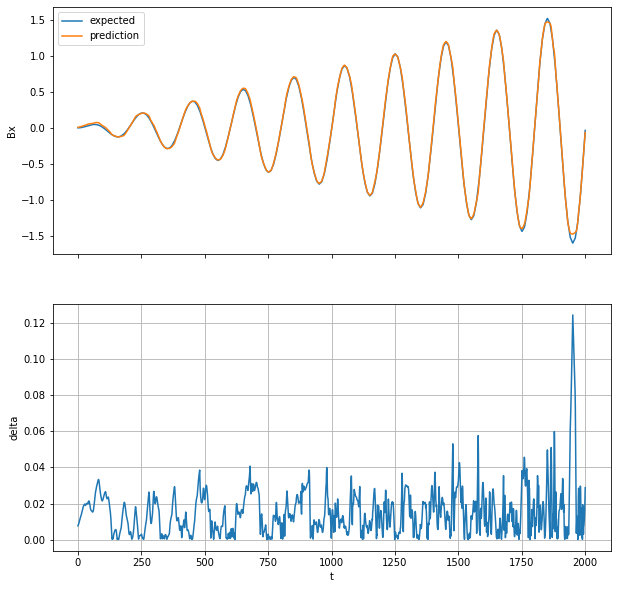

MSE: 0.00040614830774551787


In [103]:
model = tf.keras.models.load_model('./Model_GRU1_Squashed')
pred = inference_loop(model, _20PNF1500_train_X)
del model

plot_predictions(pred, _20PNF1500_train_Y, figsize=(10, 10))

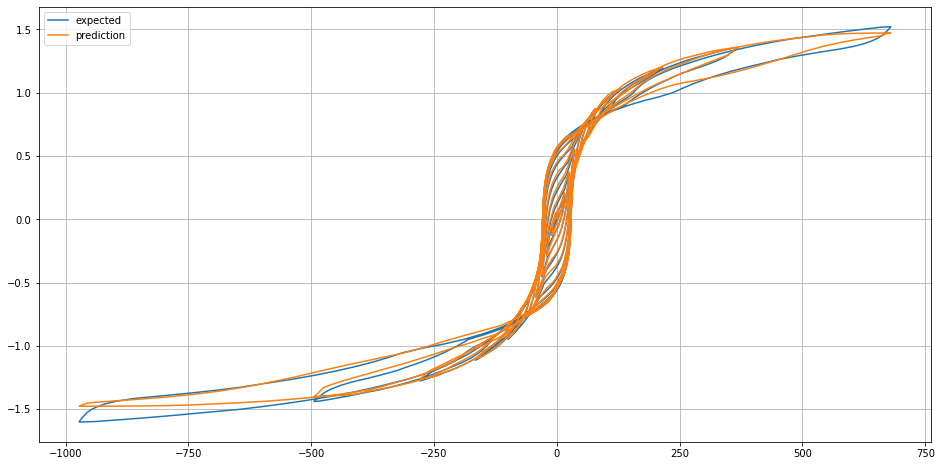

In [104]:
plt.figure(figsize=(16, 8))
plt.plot(_20PNF1500_train_X[:, -1, 0], _20PNF1500_train_Y, label='expected')
plt.plot(_20PNF1500_train_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

Start inference loop on 11766 samples... DONE after 600.9104697704315s


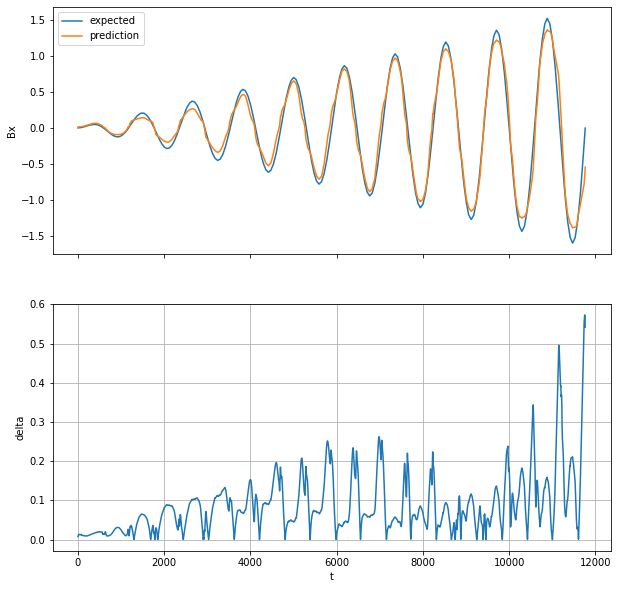

MSE: 0.013350906065178691


In [105]:
model = tf.keras.models.load_model('./Model_GRU1_Squashed')
pred = inference_loop(model, _20PNF1500_test_X)
del model

plot_predictions(pred, _20PNF1500_test_Y, figsize=(10, 10))

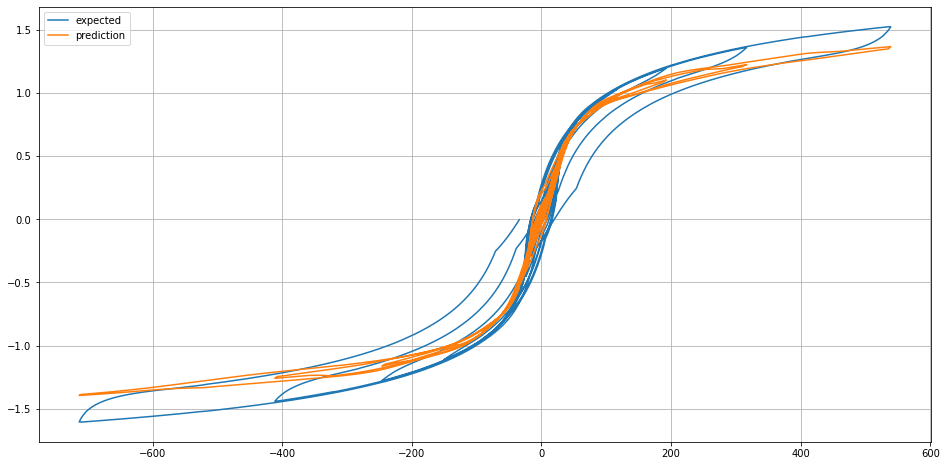

In [106]:
plt.figure(figsize=(16, 8))
plt.plot(_20PNF1500_test_X[:, -1, 0], _20PNF1500_test_Y, label='expected')
plt.plot(_20PNF1500_test_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

# The End